<a href="https://colab.research.google.com/github/SigmaGQ/InsDetek.Insider_Threat_Detection_System/blob/main/Models/LSTM/Notebook_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.display import clear_output
#@title #__InsDetek__
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')
clear_output()
# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
# notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM/Github/LSTM' # GQ
os.chdir(notebook_path);

In [ ]:
#@title #__Requirements__
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import re

import torch
import torch.nn. as F
from sklearn.metrics import *

from Model.data_preparation import Data_preparation
from Model.network import LSTM_network
from Model.evaluation import Evaluation
from Model.trainer import train
from Model.focalloss import FocalLoss

# Read Data

In [ ]:
data_path = 'data/data_3.1.csv'
split_size = [0.8, 0.1, 0.1]
batchsize = 32
data = Data_preparation(data_path, 'idx')
# data = data_preparation(data_path)
data.read_data().split(split_size).dataloader(batchsize)
# clear_output()

====== Read Data ======
read 'data/data_3.1.csv', shape = (19381, 405)

====== Split Data ======
size =  [0.8, 0.1, 0.1]
train: (15496, 405) - 614 users
valid: (1888, 405) - 77 users
test : (1997, 405) - 77 users

====== DataLoader ======
[Train Data] Input DataFrame: (15496, 405) with 14.89% insiders
   => 614 sequences (users)
       features: [43, 403], labels: [43] in size of [(max) length, dimension]
   => 19 batches in Dataloader (batchsize = 32)
       features: [32, 47, 403], labels: [32, 42], masks: [32, 44] in size of [batchsize, (max) length, dimension]

[Valid Data] Input DataFrame: (1888, 405) with 14.04% insiders
   => 77 sequences (users)
       features: [13, 403], labels: [13] in size of [(max) length, dimension]
   => 2 batches in Dataloader (batchsize = 32)
       features: [32, 48, 403], labels: [32, 48], masks: [32, 35] in size of [batchsize, (max) length, dimension]

[Test Data] Input DataFrame: (1997, 405) with 16.47% insiders
   => 77 sequences (users)
       fe

# Training

In [ ]:
model = LSTM_network(input_size = data.feat_size, num_class = data.num_class, batch_size = data.batch_size)
loss_function = FocalLoss(gamma=5., alpha=0.85)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs_num = 200
loss_list, metric_df = train(model, epochs_num, data, optimizer, loss_function)
# loss_list_sf, valid_loss_list_sf, recall_list_sf = train(model, epochs_num, train_data, optimizer, loss_function)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

# Results

In [ ]:
loss_df = pd.DataFrame(columns = ['epoch', 'batch', 'loss'])
for i, epoch_i_loss in enumerate(loss_list):
    epoch_loss = []
    for batch_j_loss in epoch_i_loss:
        epoch_loss.append(float(batch_j_loss.detach().numpy()))
    df_temp = pd.DataFrame(columns = ['epoch', 'batch', 'loss'])
    df_temp['batch'] = list(range(len(epoch_i_loss)))
    df_temp['epoch'] = float(i)    
    df_temp['epoch'] = df_temp['epoch'].astype(float)
    df_temp['loss'] = epoch_loss
    loss_df = loss_df.append(df_temp)
loss_df = loss_df.reset_index(drop=True)

color_list = ['rgb({0}, {0}, {0})'.format(int(i/epochs_num*255)) for i in range(epochs_num)]
# fig = px.line(loss_df[loss_df['epoch']%10 == 0], x = 'batch', y = 'loss', color = 'epoch', color_discrete_sequence= color_list)
fig = px.line(loss_df, x = 'batch', y = 'loss', color = 'epoch', color_discrete_sequence= color_list)
fig.update_layout(plot_bgcolor='#a1afc9')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

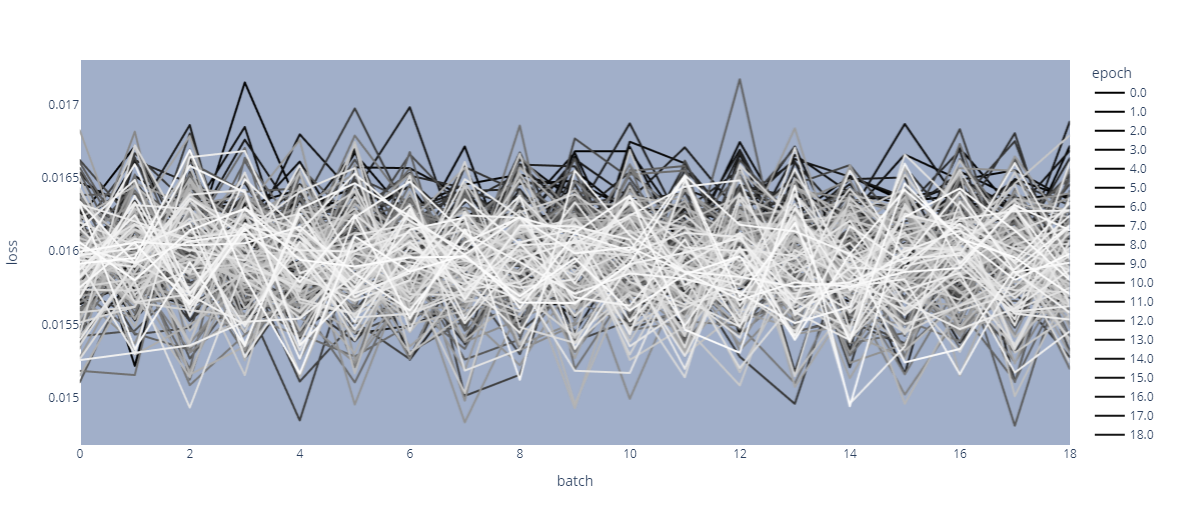

In [ ]:
# #@title Train & Valid Loss
# train_valid_loss = loss_df.groupby('epoch').mean().reset_index()
# train_valid_loss['valid'] = 0

# valid_loss = pd.DataFrame(columns = ['loss', 'valid'])
# valid_loss['loss'] = valid_loss_list
# valid_loss['loss'] = valid_loss['loss'].astype(float)
# valid_loss['valid'] = 1
# valid_loss = valid_loss.reset_index()
# valid_loss = valid_loss.rename(columns={'index':'epoch'})
# train_valid_loss = train_valid_loss.append(valid_loss)
# px.line(train_valid_loss, x = 'epoch', y = 'loss', color = 'valid')

train_valid_loss = loss_df.groupby('epoch').mean().reset_index()
train_valid_loss['valid'] = 0

valid_loss = pd.DataFrame(columns = ['loss', 'valid'])
valid_loss['loss'] = metric_df['avg_loss']
valid_loss['loss'] = valid_loss['loss'].astype(float)
valid_loss['valid'] = 1
valid_loss = valid_loss.reset_index()
valid_loss = valid_loss.rename(columns={'index':'epoch'})
train_valid_loss = train_valid_loss.append(valid_loss)
px.line(train_valid_loss, x = 'epoch', y = 'loss', color = 'valid')

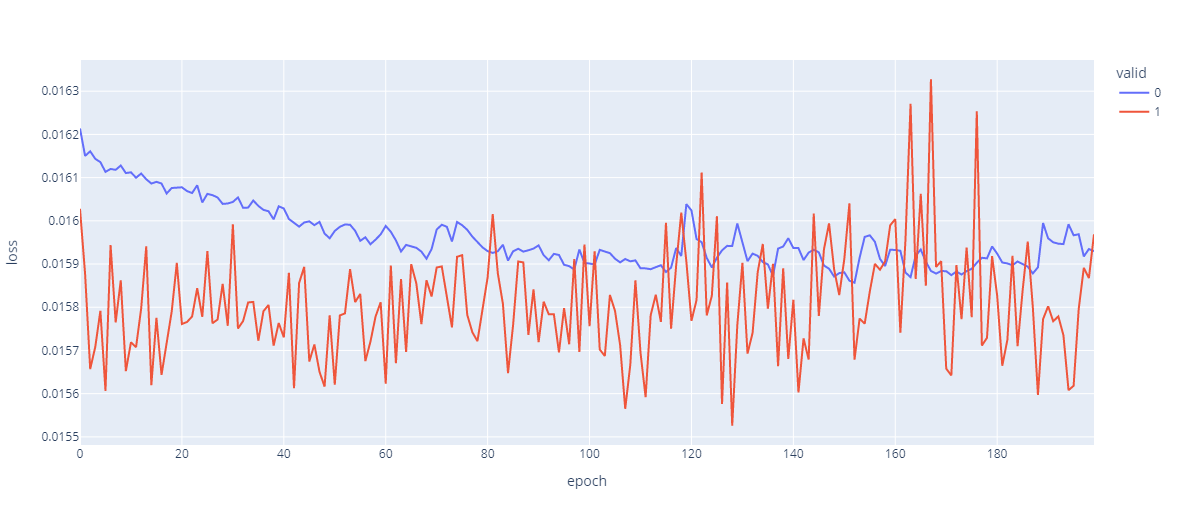

In [ ]:
# # @title Validation Recall & Precision
# recall_df = pd.DataFrame(recall_list, columns = ['recall of 0', 'recall of 1']).melt().reset_index()
# recall_df['index'] = recall_df['index'].map(lambda x: x % epochs_num)
# recall_df = recall_df.rename(columns={'index':'epoch', 'variable':'label', 'value':'recall'})
# px.line(recall_df, x = 'epoch', y = 'recall', color = 'label')

# @title Validation Recall
recall_df = metric_df[['recall_0', 'recall_1', 'precision_0', 'precision_1']].melt().reset_index().rename(columns={'recall_0':'recall of 0 (clean)', 'recall_1':'recall of 1(malicious)'})
recall_df['index'] = recall_df['index'].map(lambda x: x % epochs_num)
recall_df = recall_df.rename(columns={'index':'epoch', 'variable':'label', 'value':'rate'})
px.line(recall_df, x = 'epoch', y = 'rate', color = 'label')

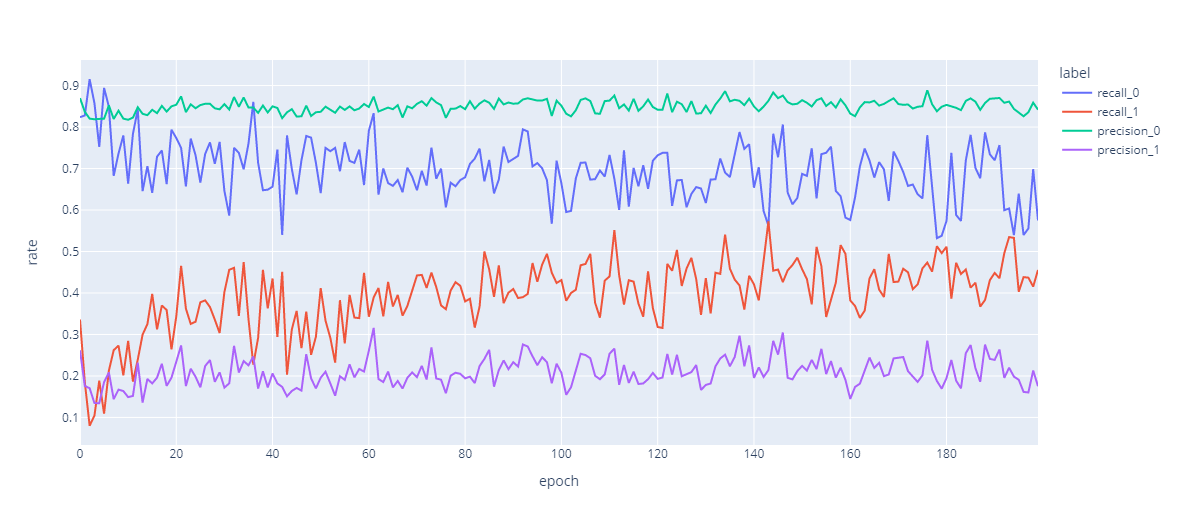

In [ ]:
#@title Recall by epochs
recall_df = metric_df[['recall_0','recall_1']].reset_index()
recall_df['index'] = recall_df['index'].astype(str)
fig = px.scatter(recall_df, x='recall_1', y='recall_0', color = 'index', color_discrete_sequence = color_list)
fig.update_layout(plot_bgcolor='#a1afc9')
fig.update_layout(title="Recall 0 vs 1", title_font_size=20)

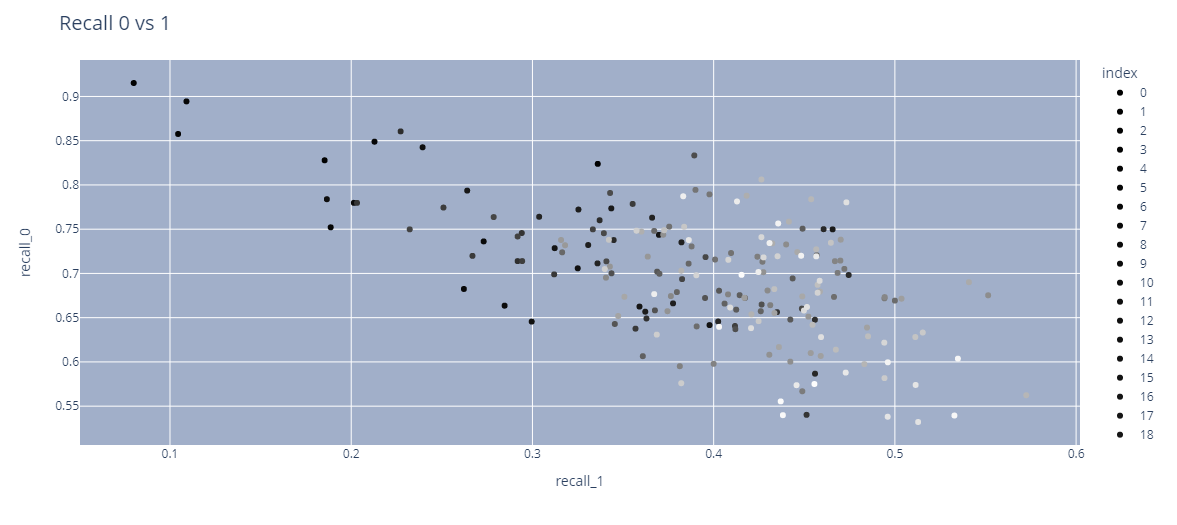

In [ ]:
#@title Precision-Recall by epochs
recall_df = metric_df[['precision_1','recall_1']].reset_index()
recall_df['index'] = recall_df['index'].astype(str)
fig = px.scatter(recall_df, x='precision_1', y='recall_1', color = 'index', color_discrete_sequence = color_list)
fig.update_layout(plot_bgcolor='#a1afc9')
fig.update_layout(title="P-R on 1", title_font_size=20)

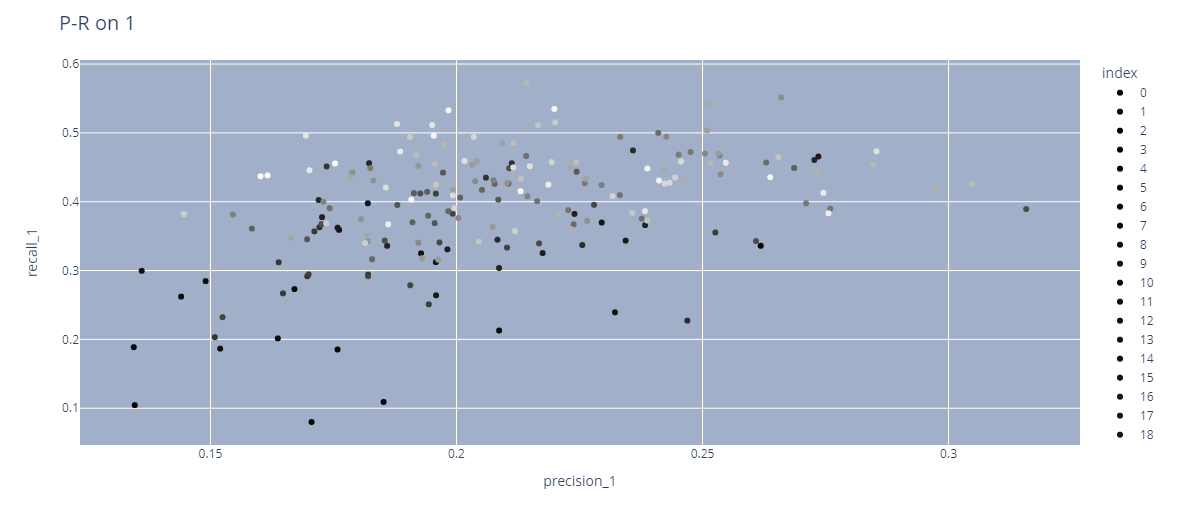

In [ ]:
#@title Model Performance
max_rate = [0, 0, 0, 0] # acc, tpr, fpr, mean
max_epoch = [0, 0, 0, 0]
rate_list = []
for i in range(200):
    best_model = torch.load('log/saved model/epoch'+str(i)+'.pth')['model']
    test = Evaluation(best_model, data)
    test('test').get_metrics()
    rate = [test.acc, test.tpr, test.fpr]
    rate_list.append(rate)

    for j in range(3):
        if rate[j] > max_rate[j]:
            max_rate[j] = rate[j]
            max_epoch[j] = i
    if np.mean(rate) > max_rate[3]:
        max_rate[3] = np.mean(rate)
        max_epoch[3] = i

print(max_epoch)
print(max_rate)
rate_df = pd.DataFrame(rate_list, columns = ['acc','tpr','fpr']).reset_index().melt(id_vars='index').rename(columns={'index':'epoch','variable':'metric','value':'rate'})
px.line(rate_df, x='epoch',y='rate',color='metric')

[5, 111, 178, 111]
[0.8192161820480405, 0.5688888888888889, 0.4947683109118087, 0.5185361015306237]


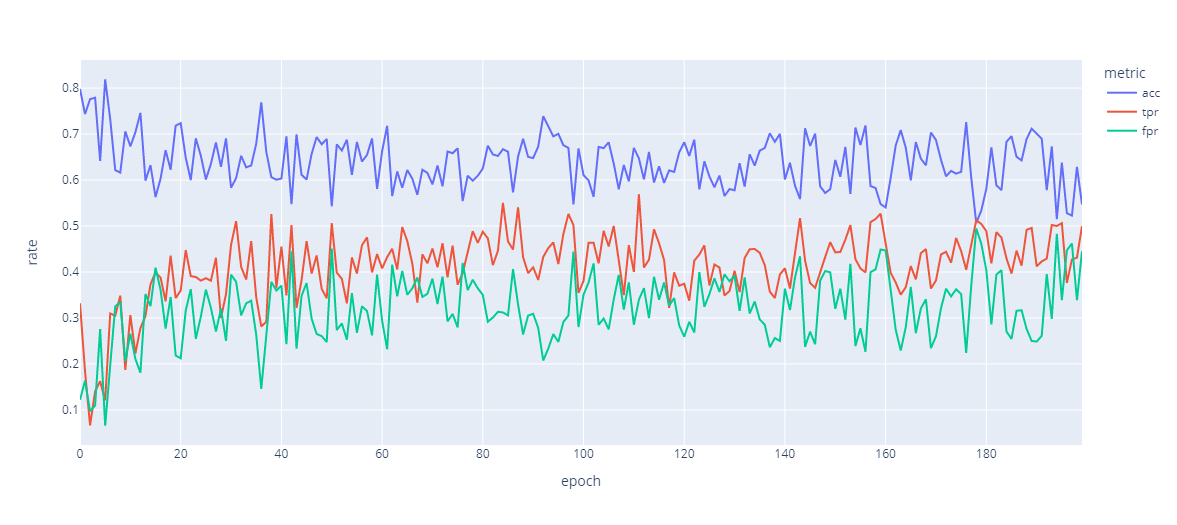

In [ ]:
best_model = torch.load('log/saved model/epoch111.pth')['model']
test = Evaluation(best_model, data)
test('test').get_metrics(True)
print('   ACC     TPR     FPR')
print(format(test.acc,'.2%'),'|', format(test.tpr,'.2%'), '|', format(test.fpr,'.2%'))

              precision    recall  f1-score   support

           0       0.88      0.68      0.77      1302
           1       0.23      0.51      0.32       244

    accuracy                           0.65      1546
   macro avg       0.55      0.59      0.54      1546
weighted avg       0.78      0.65      0.70      1546

   ACC     TPR     FPR
65.20% | 50.82% | 32.10%


# Save log

In [ ]:
def write_log(exp_n, comment):
    exp = str(exp_n).zfill(3)
    path = 'log/exp' + exp + '/'
    if os.path.exists(path):
        print("=== Overwriting!!! ===")
    else:
        os.makedirs(path)   

    with open("log/log.txt","a") as f:
        f.write('\r\n\r\n' + exp)
        f.write('\r\n\t' + comment)

    dic = {'model':model, 'optim':optimizer}
    torch.save(dic, path +'model_optim.pth')

    print(path)
    return path


In [ ]:
info =  '==== model info ====\n'\
        + 'batchsize=' + str(batch_size)\
        + '\n' + 'optim=' + optimizer.__class__.__name__\
        + '(lr={:g})'.format(optimizer.param_groups[0]['lr'])
print(info)
comment = """
data3.1.csv
100 epochs lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2
""" + info

In [ ]:
exp_nums = re.findall('\d{3}', str(os.listdir('log')))
exp_new = max(list(map(lambda x: int(x), exp_nums))) + 1

In [ ]:
path = write_log(exp_new, comment)

In [ ]:
def loss_plot(loss_list, save=True):
    losslist = []
    for i in loss_list:
        losslist.append(float(i.detach().numpy()))
    note = '\n $\mathbf{data3.2, cov-cov-lstm-}$'
    plt.figure(figsize = (10,5))
    plt.suptitle(note + re.findall('LSTMTagger\(\\n(.+)\\n\)$',str(model), re.S)[0], y = -0.001)
    plt.subplot(1,2,1)
    plt.plot(losslist)
    plt.subplot(1,2,2)
    plt.plot(losslist)
    plt.ylim(0,5)
    if save:
        plt.savefig(path + 'loss.jpg', bbox_inches='tight')
    return losslist
# losslist = loss_plot(loss_list)

In [ ]:
loss_df = pd.DataFrame(losslist)#.reset_index(drop=False)
loss_df.columns = ['loss']#['epoch', 'loss']
loss_df.to_csv(path+'loss.csv', index = False)